In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.dpi"] = 120
plt.rcParams["axes.labelsize"] = 17
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12

# Import

In [2]:
clouds = ["lmc","smc"]
data = {"I":{},"W":{},"W*":{}}
subsets = {"few_n":{},"many_n":{},"few_peak":{},"many_peak":{},"good":{},"bad":{}}

peaks = {cloud:pd.read_json(f"{cloud}_peaks.json",orient='index')[["freqs","peak_heights"]] for cloud in  ["lmc","smc"]}
for cloud in clouds:
    peaks[cloud]['n_peaks'] = peaks[cloud].freqs.apply(len)
    
n_thr = {'lmc':50,'smc':50}
peak_thr = {'lmc':15,'smc':20}
for cloud in clouds:
    data["I"][cloud] = pd.read_json(f"{cloud}_results.json",orient='index')
    data["W"][cloud] = pd.read_json(f"{cloud}_wesenheit.json")
    data["W"][cloud] = data["W"][cloud].join(data["I"][cloud]).join(peaks[cloud])
    
    subsets["few_n"][cloud] = data["W"][cloud][data["W"][cloud].n < n_thr[cloud]].index
    subsets["many_n"][cloud] = data["W"][cloud][data["W"][cloud].n > n_thr[cloud]].index
    subsets["few_peak"][cloud] = data["W"][cloud][data["W"][cloud].n_peaks < peak_thr[cloud]].index
    subsets["many_peak"][cloud] = data["W"][cloud][data["W"][cloud].n_peaks > peak_thr[cloud]].index

## inspect number of peaks

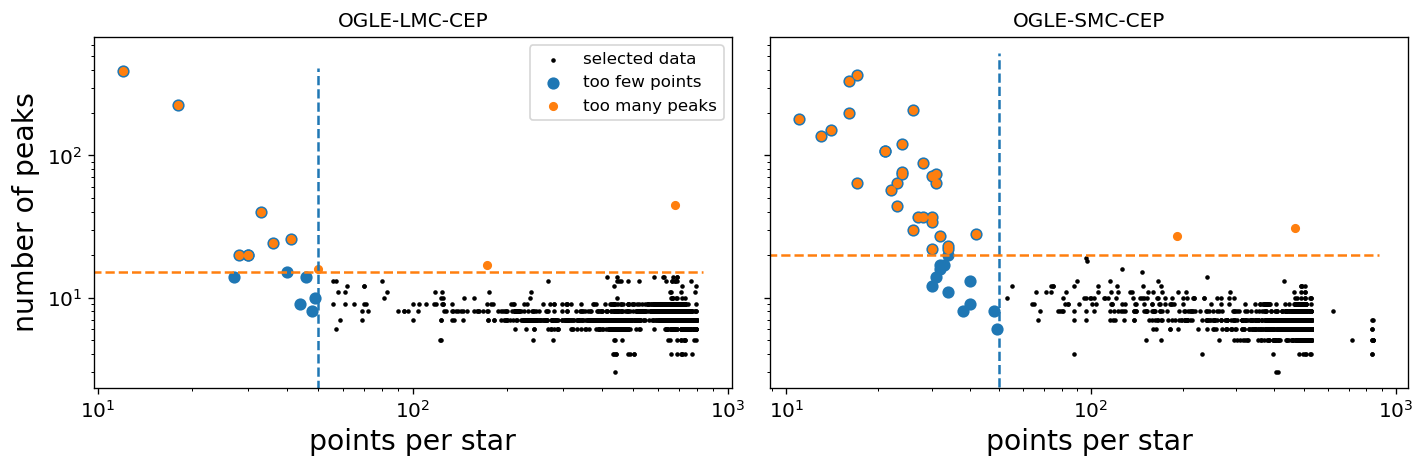

In [3]:
fig,ax = plt.subplots(ncols=2,figsize=(12,4),sharey=True)

for i,cloud in enumerate(["lmc","smc"]):
    plt.sca(ax[i])
    W = data["W"][cloud]
    plt.scatter(W.n,W.n_peaks,s=3,c='k',label="selected data")
    plt.scatter(W.n.loc[subsets["few_n"][cloud]],W.n_peaks.loc[subsets["few_n"][cloud]],s=40,label="too few points")
    plt.scatter(W.n.loc[subsets["many_peak"][cloud]],W.n_peaks.loc[subsets["many_peak"][cloud]],s=20,label="too many peaks")
    
    plt.plot([n_thr[cloud],n_thr[cloud]],ax[i].get_ylim(),"--")
    plt.plot(ax[i].get_xlim(),[peak_thr[cloud],peak_thr[cloud]],"--")
    
    plt.xscale("log")
    if i == 0:
        plt.ylabel("number of peaks")
        plt.yscale("log")
        plt.legend()
    plt.xlabel("points per star")
    plt.title(f"OGLE-{cloud.upper()}-CEP")
    
plt.tight_layout()
plt.savefig("results/peaks_vs_points.pdf")

Number of peaks greater than half the maximum peak, to eliminate the noise peaks on the spectrum

## Define good and bad data

In [4]:
for cloud in clouds:
    subsets["good"][cloud] = np.intersect1d(subsets["many_n"][cloud],subsets["few_peak"][cloud])
    subsets["bad"][cloud] = np.union1d(subsets["few_n"][cloud],subsets["many_peak"][cloud])

# PL relation

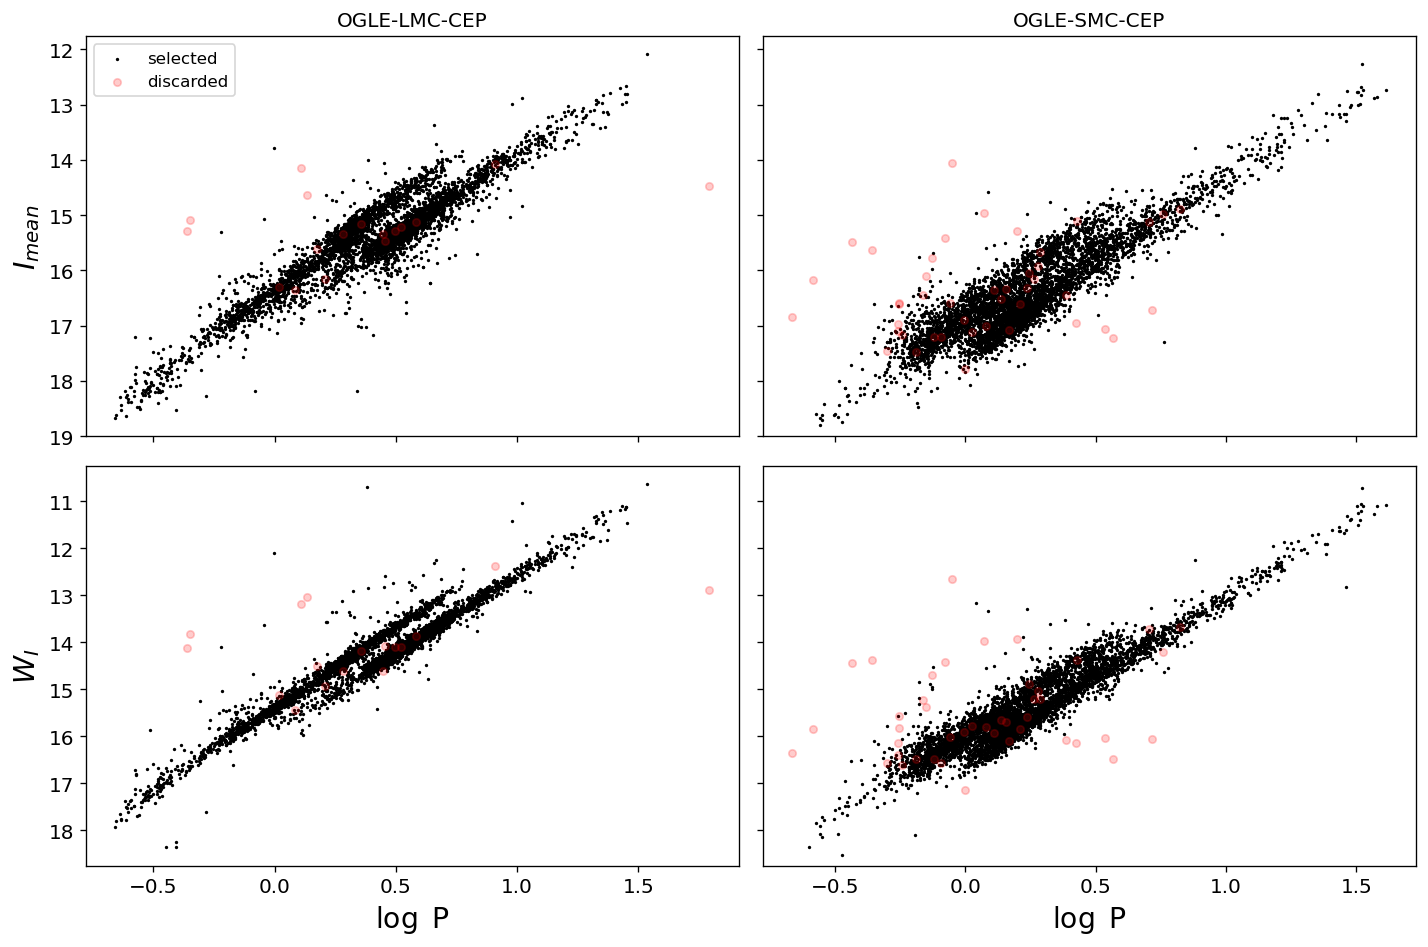

In [5]:
fig,ax = plt.subplots(ncols=2,nrows=2,figsize=(12,8),sharey='row',sharex='col')
s = 1
sd = 20

for i,cloud in enumerate(["lmc","smc"]):
    good = data["W"][cloud].loc[subsets["good"][cloud]]
    bad = data["W"][cloud].loc[subsets["bad"][cloud]]
    
    plt.sca(ax[0,i])
    plt.title(f"OGLE-{cloud.upper()}-CEP")
    plt.scatter(-np.log10(good.freq),good.I_mean,s=s,c='k',label="selected")
    plt.scatter(-np.log10(bad.freq),bad.I_mean,s=sd,alpha=0.2,c='r',label="discarded")
    if i == 0:
        plt.ylim(*np.flip(plt.gca().get_ylim()))
        plt.ylabel("$I_{mean}$")
        plt.legend()
    
    plt.sca(ax[1,i])
    plt.scatter(-np.log10(good.freq),good.W,s=s,c='k',label="selected")
    plt.scatter(-np.log10(bad.freq),bad.W,s=sd,alpha=0.2,c='r',label="discarded")
    if i == 0:
        plt.ylim(*np.flip(plt.gca().get_ylim()))
        plt.ylabel("$W_I$")
    plt.xlabel("$\\log$ P")

plt.tight_layout()
#plt.savefig("results/PL_realtion.pdf")

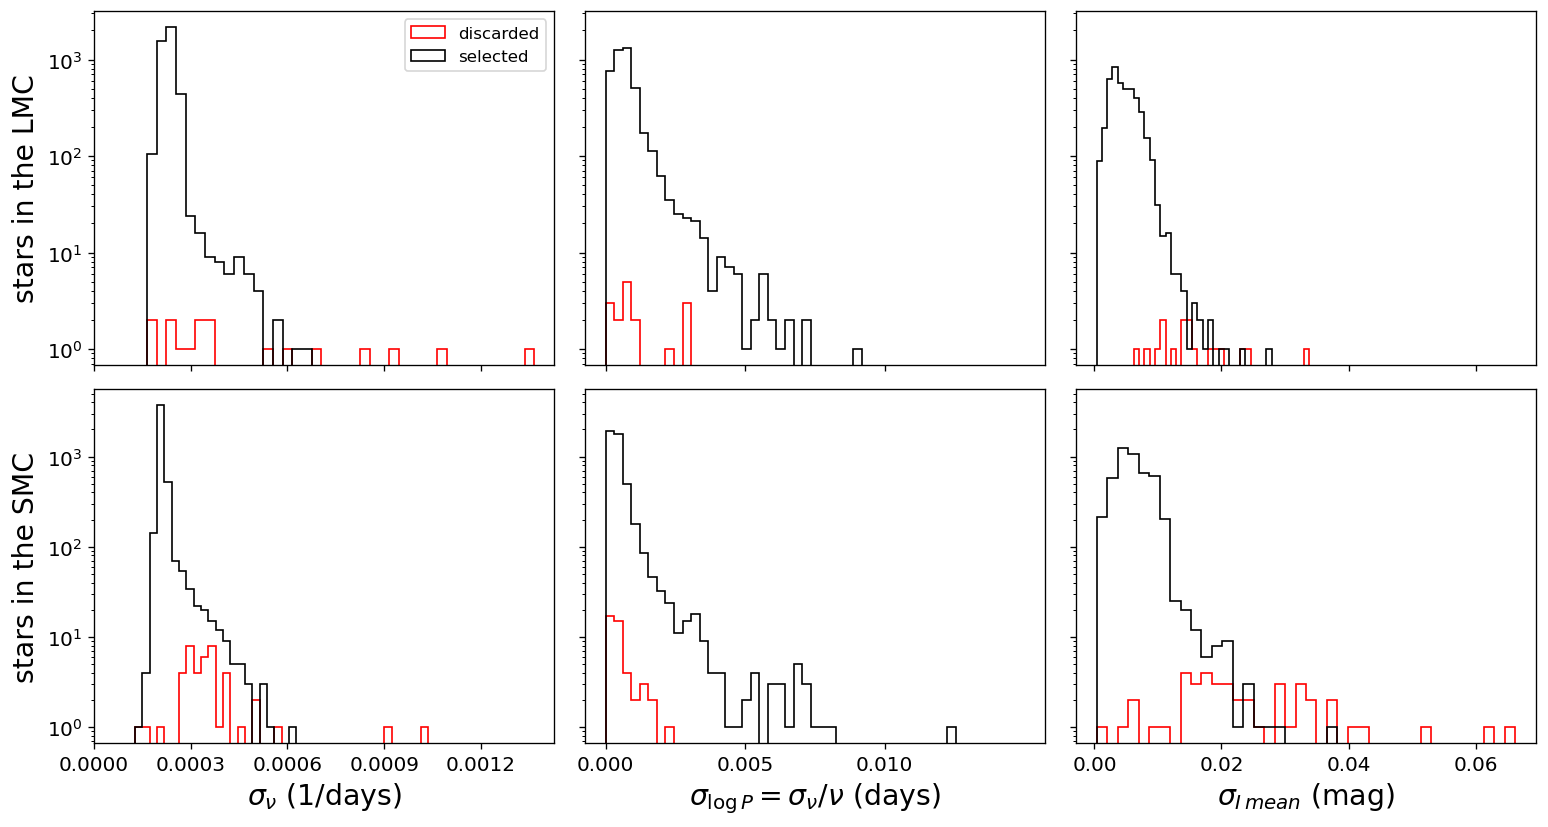

In [55]:
fig,ax = plt.subplots(nrows=2,ncols=3,sharex='col',sharey='row',figsize=(13,7))
bins = 40
hist = dict(log=True,histtype='step',color=['k','r'],label=["selected","discarded"])

for i,cloud in enumerate(["lmc","smc"]):
    good = data["W"][cloud].loc[subsets["good"][cloud]]
    bad = data["W"][cloud].loc[subsets["bad"][cloud]]
    
    plt.sca(ax[i,0])
    plt.ylabel(f"stars in the {cloud.upper()}")
    plt.hist([good.sigma_freq,bad.sigma_freq],bins,**hist)
    
    if i == 0:
        plt.legend()
    else:
        plt.xlabel(r"$\sigma_{\nu}$ (1/days)")
        plt.xticks(np.arange(0,0.0013,0.0003))
        
    plt.sca(ax[i,1])
    plt.hist([good.sigma_freq/good.freq,bad.sigma_freq/bad.freq],np.linspace(0,0.015),**hist)
    if i == 1:
        #plt.xlim(0,0.3
        plt.xticks(np.arange(0,0.015,0.005))
        plt.xlabel(r"$\sigma_{\log P} = \sigma_\nu/\nu$ (days)")
    
    plt.sca(ax[i,2])
    plt.hist([good.sigma_I_mean,bad.sigma_I_mean],bins,**hist)
    if i == 1:
        plt.xlabel(r"$\sigma_{I\, mean}$ (mag)")
        
plt.tight_layout()
#plt.savefig("results/results_uncertainties.pdf")

## Colorful

In [180]:
from tqdm import tqdm

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4341/4341 [00:46<00:00, 92.60it/s]


CPU times: user 6.18 s, sys: 282 ms, total: 6.46 s
Wall time: 5.96 s


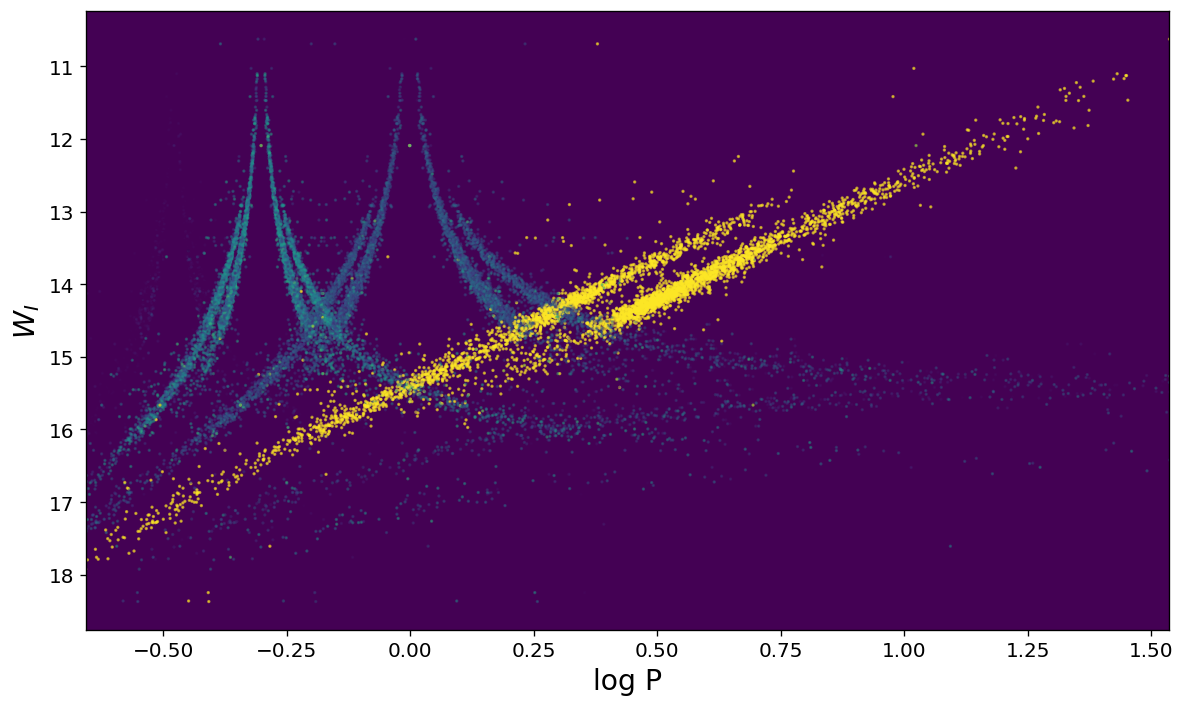

In [460]:
cloud = 'lmc'
W = data["W"][cloud].loc[subsets["good"][cloud]]

plt.figure(figsize=(10,6))
plt.gca().set_facecolor(plt.get_cmap()(0))
for i in tqdm(range(len(W.freqs))):
    colors = (np.array(W.peak_heights[i])-0.4)
    plt.scatter(-np.log10(W.freqs[i]),[W.W[i]]*W.n_peaks[i],c=colors,alpha=colors,s=1)
plt.ylim(*np.flip(plt.gca().get_ylim()))
plt.xlim(-np.log10(W.freq.max()),-np.log10(W.freq.min()))
plt.ylabel("$W_I$")
plt.xlabel("log P")
plt.tight_layout()
%time plt.savefig("lmc.png",dpi=200)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4341/4341 [00:36<00:00, 117.82it/s]


CPU times: user 5.54 s, sys: 202 ms, total: 5.74 s
Wall time: 5.26 s


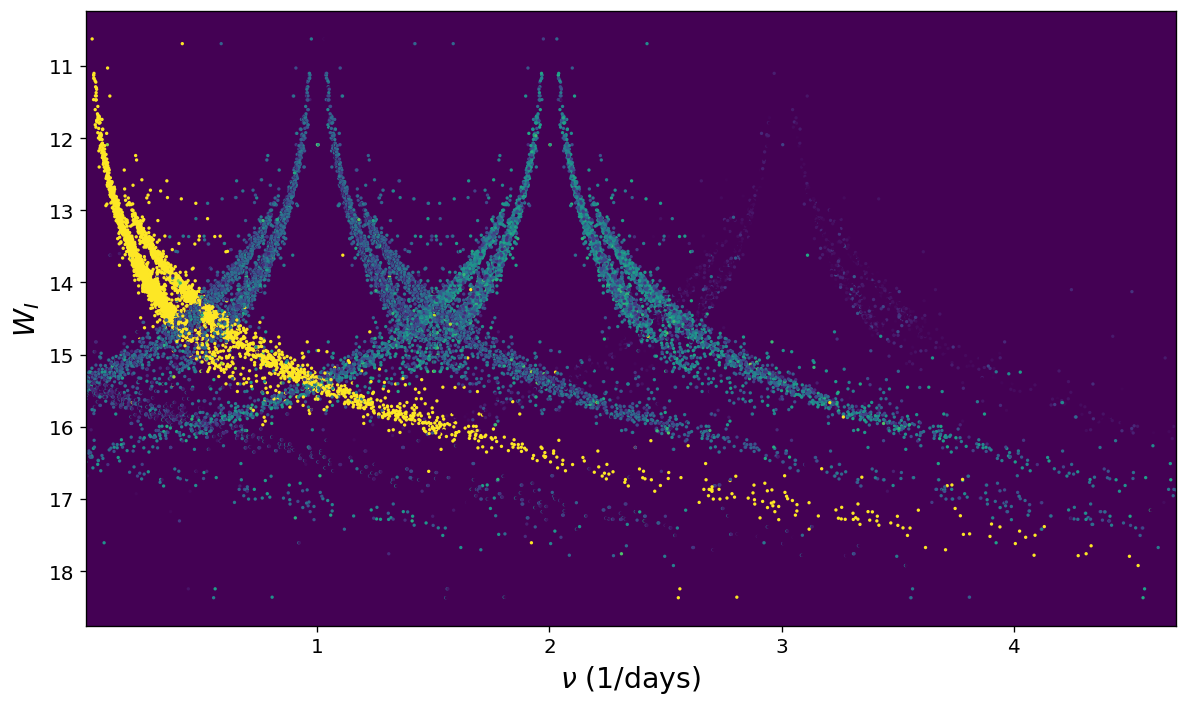

In [555]:
cloud = 'lmc'
W = data["W"][cloud].loc[subsets["good"][cloud]]

plt.figure(figsize=(10,6))
plt.gca().set_facecolor(plt.get_cmap()(0))
for i in tqdm(range(len(W.freqs))):
    colors = (np.array(W.peak_heights[i])-0.5)
    plt.scatter(W.freqs[i],[W.W[i]]*W.n_peaks[i],c=colors,s=1)
plt.ylim(*np.flip(plt.gca().get_ylim()))
plt.xlim(0.001,4.7)
plt.ylabel("$W_I$")
plt.xlabel("$\\nu$ (1/days)")
plt.tight_layout()
%time plt.savefig("lmc_freq.png",dpi=200)

some yellow dots can be seen lying around the secondary peaks. This can possibly be resolved by searching with a fined $d\tau$ around each founded peak, to find the true maximum of each one. This can be done with any of the five algorithms, as the speed should not be a problem for so few points.

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4655/4655 [00:39<00:00, 116.68it/s]


CPU times: user 7.14 s, sys: 236 ms, total: 7.38 s
Wall time: 6.91 s


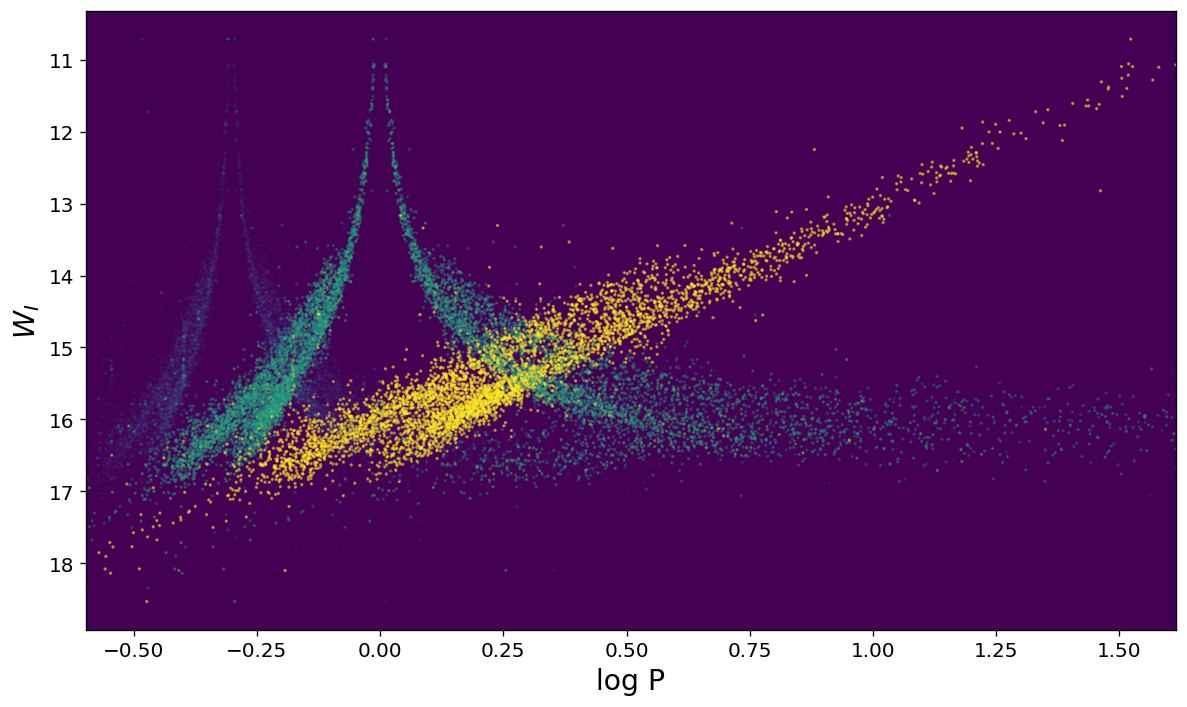

In [556]:
cloud = 'smc'
W = data["W"][cloud].loc[subsets["good"][cloud]]

plt.figure(figsize=(10,6))
plt.gca().set_facecolor(plt.get_cmap()(0))
for i in tqdm(range(len(W.freqs))):
    colors = (np.array(W.peak_heights[i])-0.5)
    plt.scatter(-np.log10(W.freqs[i]),[W.W[i]]*W.n_peaks[i],c=colors,alpha=colors,s=1)
plt.ylim(*np.flip(plt.gca().get_ylim()))
plt.xlim(-np.log10(W.freq.max()),-np.log10(W.freq.min()))
plt.ylabel("$W_I$")
plt.xlabel("log P")
plt.tight_layout()
%time plt.savefig("smc.png",dpi=200)

## Compare with OGLE

### import OGLE data

In [7]:
pd_options = dict(
    sep="\s+",
    usecols=[*range(7)],
    index_col=0,
    names=["ID","I","V","P","dP","t0","ptp"],
    na_values="-"
)
base = {}
files = {}
labels = {}
tables = {}
stats = {}

base["lmc"] = "ogle4/OCVS/lmc/cep/"
files["lmc"] = ["cepF.dat","cep1O.dat","cep2O.dat",
         "cepF1O.dat","cep1O2O.dat","cepF1O2O.dat",
         "cep1O2O3O.dat","cep1O3O.dat","cep2O3O.dat"]

base["smc"] = "ogle4/OCVS/smc/cep/"
files["smc"] = ["cepF.dat","cep1O.dat","cep2O.dat",
         "cepF1O.dat","cep1O2O.dat","cep1O2O3O.dat"]

for cloud,basepath in base.items():
    labels[cloud] = [f[3:].split(".")[0] for f in files[cloud]]
    tables[cloud] = {
        label:pd.read_table(basepath+fname,**pd_options) for fname,label in zip(files[cloud],labels[cloud])
    }
    for label,table in tables[cloud].items():
        for phot in "IV":
            table.insert(len(table.columns),"n"+phot,np.nan)
            for index in table.index:
                try:
                    with open(f"{basepath}phot/{phot}/{index}.dat","r") as file:
                        table.at[index,"n"+phot] = file.read().count("\n")
                except FileNotFoundError:
                    pass
    all_data = pd.concat(tables[cloud].values()).sort_index()
    tables[cloud]["total"] = all_data

### Compare plot

In [8]:
true_outliers = {}

for cloud in clouds:
    W = data["W"][cloud].loc[subsets["good"][cloud]].join(tables[cloud]['total'])
    true_outliers[cloud] = W[
        ((np.log10(abs(W.P-1/W.freq)) > 0) & (-np.log10(W.freq)<0)) | \
        ( (np.log10(abs(W.P-1/W.freq)) > -2) & (-np.log10(W.freq)<-0.3) & (cloud=='smc')) | \
        ( (np.log10(abs(W.P-1/W.freq)) > -0.65) & (-np.log10(W.freq)<-0.2) & (cloud=='smc'))
    ]

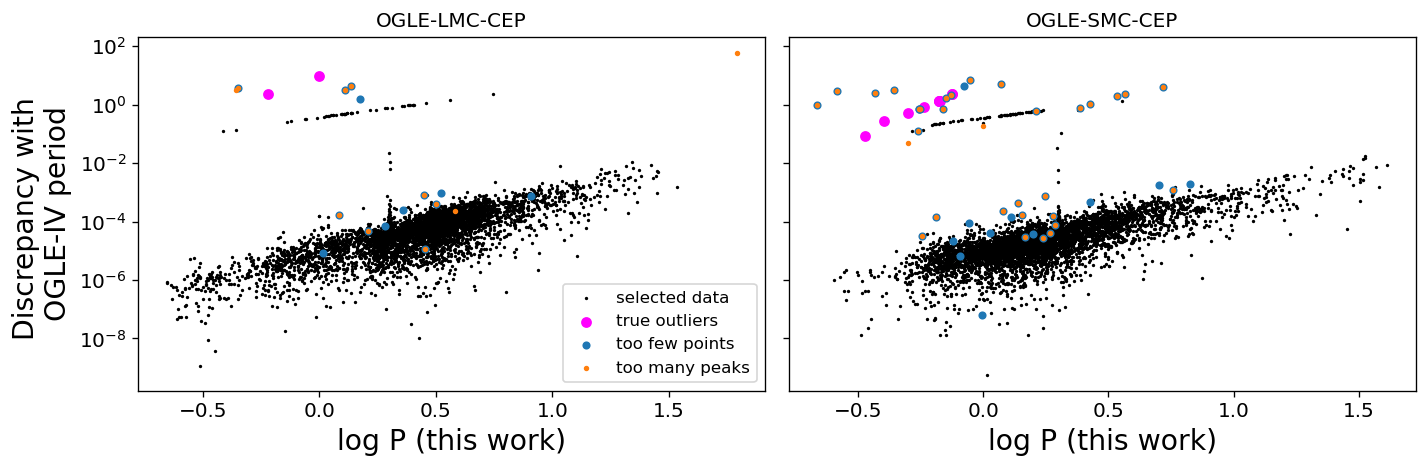

In [9]:
fig,ax = plt.subplots(ncols=2,sharey=True,figsize=(12,4))
for i,cloud in enumerate(["lmc","smc"]):
    plt.sca(ax[i])
    test = data["W"][cloud].join(tables[cloud]['total'].P)

    plt.scatter(-np.log10(test.freq),abs(test.P - 1/test.freq),s=1,c='k',label="selected data")
    plt.scatter(-np.log10(true_outliers[cloud].freq),abs(true_outliers[cloud].P-1/true_outliers[cloud].freq),s=30,c="#FF00FF",label="true outliers")
    plt.scatter(-np.log10(test.loc[subsets["few_n"][cloud]].freq),abs(test.P - 1/test.freq).loc[subsets["few_n"][cloud]],s=15,label="too few points")
    plt.scatter(-np.log10(test.loc[subsets["many_peak"][cloud]].freq),abs(test.P - 1/test.freq).loc[subsets["many_peak"][cloud]],s=5,label="too many peaks")
    if i == 0:
        plt.yscale("log")
        plt.legend()
        plt.ylabel("Discrepancy with \nOGLE-IV period")
    plt.xlabel("log P (this work)")
    plt.title(f"OGLE-{cloud.upper()}-CEP")
    
plt.tight_layout()
#plt.savefig("results/discrepancies.pdf")

No a-priori way to select the discrepancy line was found.
The stars on the discrepancy line all have a typical number of peaks and data points.

In [10]:
for cloud in clouds:
    W = data["W"][cloud].loc[subsets["good"][cloud]].join(tables[cloud]['total'].P)
    less = sum(abs(W.P - 1/W.freq) < 0.01)
    total = len(W.P)
    print(cloud,f"good: {less/total*100:.2f}",total-less)

lmc good: 98.83 51
smc good: 98.20 84


## Mystery vertical line

In [11]:
mistery_line = {}

for i,cloud in enumerate(clouds):
    W = data["W"][cloud].loc[subsets["good"][cloud]].join(tables[cloud]['total'].P)
    mask = (np.log10(abs(W.P-1/W.freq)) < -0.8) & (np.log10(abs(W.P-1/W.freq)) > -3.8 ) & (-np.log10(W.freq) < 0.32) & (-np.log10(W.freq) > 0.28)
    mistery_line[cloud] = W[mask]
    print(sum(mask))

13
12


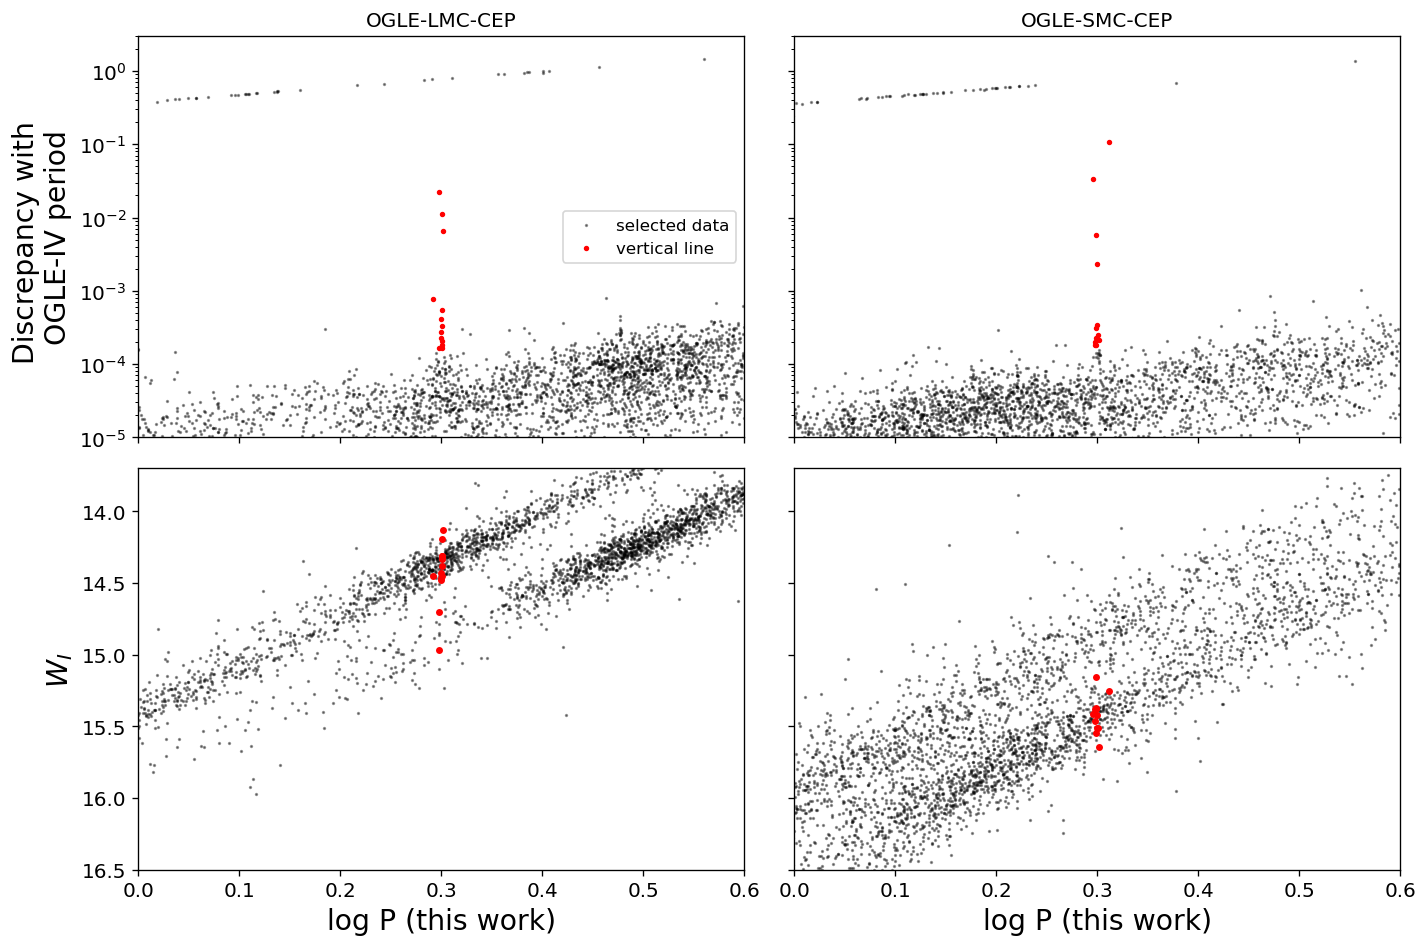

In [12]:
fig,ax = plt.subplots(ncols=2,nrows=2,figsize=(12,8),sharey='row',sharex=True)

for i,cloud in enumerate(["lmc","smc"]):
    plt.sca(ax[0,i])
    W = data["W"][cloud].loc[subsets["good"][cloud]].join(tables[cloud]['total'].P)
    plt.scatter(-np.log10(W.freq),abs(W.P - 1/W.freq),s=1,c='k',label="selected data",alpha=0.4)
    plt.scatter(-np.log10(mistery_line[cloud].freq),abs(mistery_line[cloud].P - 1/mistery_line[cloud].freq),s=5,c='r',label="vertical line")
    
    if i == 0:
        plt.yscale("log")
        plt.legend(loc="best")
        plt.ylabel("Discrepancy with \nOGLE-IV period")
        plt.ylim(1e-5,3)
    #plt.xlabel("log P (this work)")
    plt.title(f"OGLE-{cloud.upper()}-CEP")
    
    plt.sca(ax[1,i])
    
    plt.scatter(-np.log10(W.freq),W.W,s=1,c="k",alpha=0.4)
    plt.scatter(-np.log10(mistery_line[cloud].freq),mistery_line[cloud].W,c='r',s=10)
    
    if i == 0:
        plt.ylabel("$W_I$")
        plt.ylim(*np.flip(plt.gca().get_ylim()))
        plt.xlim(-0,0.6)
        plt.ylim(16.5,13.7)
    plt.xlabel("log P (this work)")
    
plt.tight_layout()
#plt.savefig("results/vertial_line_detail.pdf")

## Mode horizontal line

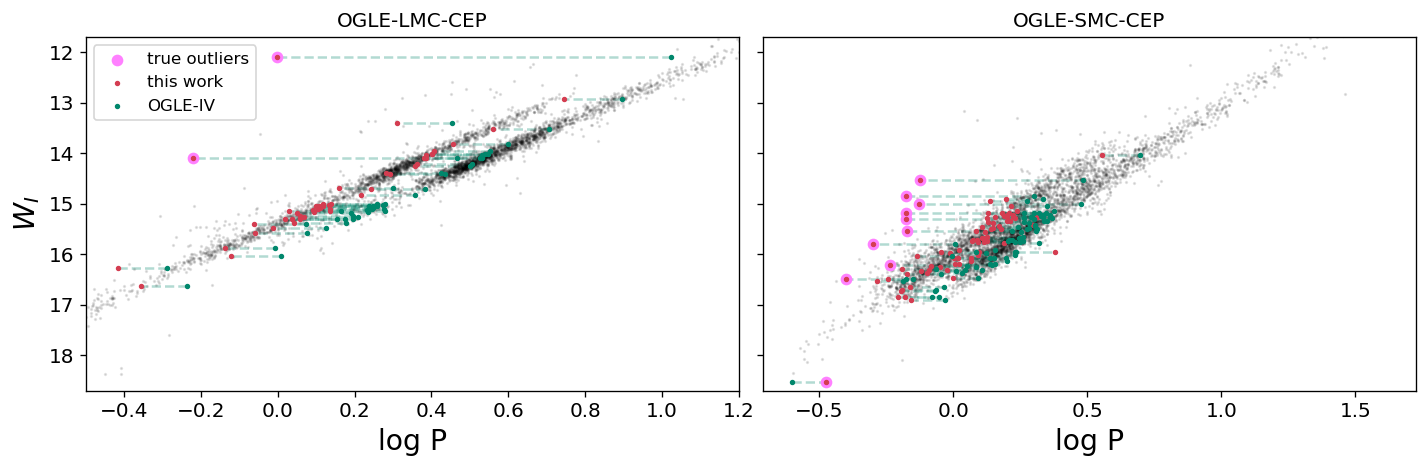

In [13]:
fig,ax = plt.subplots(ncols=2,sharey=True,figsize=(12,4))
for i,cloud in enumerate(clouds):
    plt.sca(ax[i])
    W = data["W"][cloud].loc[subsets["good"][cloud]].join(tables[cloud]['total'].P)
    mask = np.log10(abs(W.P-1/W.freq)) > -1.5
    
    plt.scatter(-np.log10(W.freq),W.W,s=1,c="k",alpha=0.1)
    plt.scatter(-np.log10(true_outliers[cloud].freq),true_outliers[cloud].W,c="#FF80FF",label="true outliers")
    plt.scatter(-np.log10(W[mask].freq),W[mask].W,s=5,c="#d43d51",label="this work")
    plt.scatter(np.log10(W[mask].P),W[mask].W,s=5,c="#00876c",label="OGLE-IV")
    for _,row in W[mask].iterrows():
        plt.plot([np.log10(row.P),-np.log10(row.freq)],[row.W]*2,"--",c="#00876c",alpha=0.3,zorder=-1)
    
    if i == 0:
        plt.legend()
        plt.ylabel("$W_I$")
        plt.ylim(*np.flip(plt.gca().get_ylim()))
        plt.xlim(-0.5,1.2)
        plt.ylim(18.7,11.7)
    plt.xlabel("log P")
    plt.title(f"OGLE-{cloud.upper()}-CEP")
    
plt.tight_layout()
#plt.savefig("results/horizontal_line_corrections.pdf")

### Where does the lines and true outliers lie in the modes?

#### vertical line

In [14]:
for cloud in clouds:
    print(cloud)
    for mode in tables[cloud].keys():
        if mode != "total":
            intersection = np.intersect1d(mistery_line[cloud].index,tables[cloud][mode].index)
            print("\t",mode,len(intersection))
    print("   ",len(mistery_line[cloud]))

lmc
	 F 2
	 1O 11
	 2O 0
	 F1O 0
	 1O2O 0
	 F1O2O 0
	 1O2O3O 0
	 1O3O 0
	 2O3O 0
    13
smc
	 F 11
	 1O 1
	 2O 0
	 F1O 0
	 1O2O 0
	 1O2O3O 0
    12


In [24]:
13+12

25

#### horizontal line

In [15]:
for cloud in clouds:
    W = data["W"][cloud].loc[subsets["good"][cloud]].join(tables[cloud]['total'].P)
    mask = np.log10(abs(W.P-1/W.freq)) > -1.5
    
    horizontal_stars = np.setdiff1d(W[mask].index ,true_outliers[cloud].index)
    
    print(cloud)
    for mode in tables[cloud].keys():
        if mode != "total":
            intersection = np.intersect1d(horizontal_stars,tables[cloud][mode].index)
            print("\t",mode,len(intersection))
            if len(intersection) < 10 and len(intersection) != 0:
                print("\t\t",[s.split("-")[-1] for s in intersection])
    print("    ",len(horizontal_stars))

lmc
	 F 0
	 1O 0
	 2O 0
	 F1O 44
	 1O2O 0
	 F1O2O 1
		 ['1378']
	 1O2O3O 0
	 1O3O 0
	 2O3O 0
     45
smc
	 F 4
		 ['0473', '1029', '2792', '4675']
	 1O 0
	 2O 0
	 F1O 63
	 1O2O 2
		 ['0998', '4784']
	 1O2O3O 0
     69


In [23]:
45+69

114

#### outliers

In [22]:
for cloud in clouds:
    print(cloud)
    for mode in tables[cloud].keys():
        if mode != "total":
            tru = np.intersect1d(true_outliers[cloud].index,tables[cloud][mode].index)
            print("\t",mode,[s.split("-")[-1] for s in tru])
    print("    ",len(true_outliers[cloud]))

lmc
	 F ['0016', '4668']
	 1O []
	 2O []
	 F1O []
	 1O2O []
	 F1O2O []
	 1O2O3O []
	 1O3O []
	 2O3O []
     2
smc
	 F ['1400', '2521', '2924', '3108', '4020', '4361', '4967']
	 1O ['3317', '4195']
	 2O []
	 F1O []
	 1O2O ['1350']
	 1O2O3O []
     10
